In [1]:
#numpyro.set_platform("cpu")
#numpyro.set_platform("gpu")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

この例では、phaseとノイズレベルsigmaを推定します。観測値はy1=sin(x + phase)+e, y2=cos(x+phase)+eです。

In [14]:
np.random.seed(32)
phase=0.5
sigin=0.3
N=20
x1=np.sort(np.random.rand(N))*4*np.pi
y1=np.sin(x1+phase)+np.random.normal(0,sigin,size=N)
x2=np.sort(np.random.rand(N))*4*np.pi
y2=np.cos(x2+phase)+np.random.normal(0,sigin,size=N)

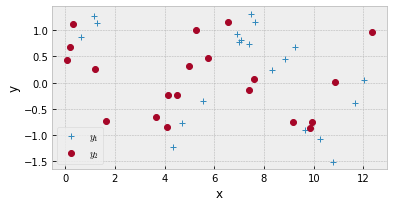

In [32]:
import seaborn as sns
plt.style.use('bmh')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x1,y1,"+",color="C0",label="$y_1$")
ax.plot(x2,y2,"o",color="C1",label="$y_2$")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc5.pdf")

In [16]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
def model(x1,x2,y1,y2):
    phase = numpyro.sample('phase', dist.Uniform(-1.0*jnp.pi, 1.0*jnp.pi))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu1=jnp.sin(x1+phase)
    mu2=jnp.cos(x2+phase)   
    numpyro.sample('y1', dist.Normal(mu1, sigma), obs=y1)
    numpyro.sample('y2', dist.Normal(mu2, sigma), obs=y2)

In [17]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x1=x1, x2=x2, y1=y1, y2=y2)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:04<00:00, 697.14it/s, 7 steps of size 7.70e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     phase      0.27      0.07      0.27      0.16      0.39   1354.01      1.00
     sigma      0.31      0.04      0.30      0.25      0.37   1447.22      1.00

Number of divergences: 0


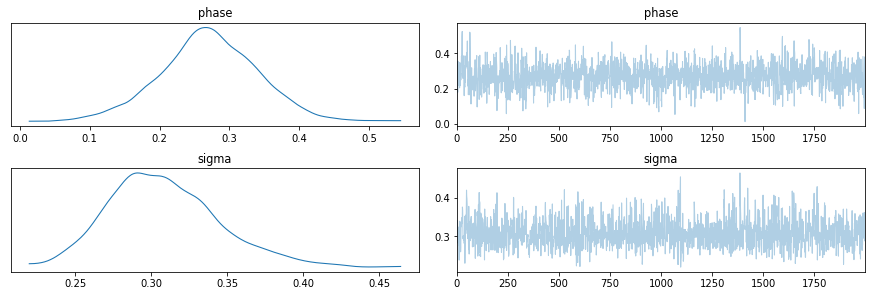

In [18]:
import arviz
arviz.plot_trace(mcmc, var_names=["phase","sigma"])
plt.savefig("hmc2x.pdf")

In [19]:
posterior_phase = mcmc.get_samples()['phase']
posterior_sigma = mcmc.get_samples()['sigma']

In [20]:
from numpyro.infer import Predictive
pred = Predictive(model,{'phase':posterior_phase,'sigma':posterior_sigma},return_sites=["y1","y2"])

In [21]:
from numpyro.infer import Predictive
pred = Predictive(model,{'phase':posterior_phase,'sigma':posterior_sigma},return_sites=["y1","y2"])
x1_ = jnp.linspace(0,4*jnp.pi,1000)
x2_ = jnp.linspace(0,4*jnp.pi,1000)
predictions = pred(rng_key_,x1=x1_,x2=x2_,y1=None,y2=None)

In [23]:
from numpyro.diagnostics import hpdi
mean_muy1 = jnp.mean(predictions["y1"], axis=0)
hpdi_muy1 = hpdi(predictions["y1"], 0.9)
mean_muy2 = jnp.mean(predictions["y2"], axis=0)
hpdi_muy2 = hpdi(predictions["y2"], 0.9)

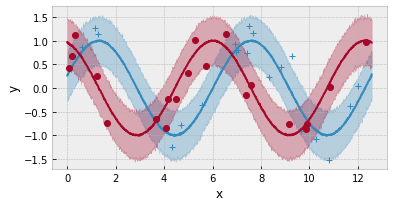

In [30]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x1,y1,"+",color="C0")
ax.plot(x1_,mean_muy1,color="C0")
ax.fill_between(x1_, hpdi_muy1[0], hpdi_muy1[1], alpha=0.3, interpolate=True,color="C0")
ax.plot(x2,y2,"o",color="C1")
ax.plot(x2_,mean_muy2,color="C1")
ax.fill_between(x2_, hpdi_muy2[0], hpdi_muy2[1], alpha=0.3, interpolate=True,color="C1")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc6.pdf")